# Introduction
This page is intended to demonstrate peaking fitting functionality available in the *RamanAnalysis* Python module. The original purpose of the module is to facilitate the fitting of Raman and photoluminescence peaks in a semi-automatic manner. Nevertheless, it's likely that this module could perform a similar function for other data sets which feature peaks (such as XRD, CL, IR, mass spec, etc.).

# Getting Started

## Import some packages

In [1]:
# Standard Packages
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import sys , os

# Custom modules
sys.path.append('C:/Users/Jesse/OneDrive/Python-Stuff/Research/Ishigami-Git-Projects/data-analysis/') # Specifies custom module directory
import RamanAnalysis
import dataIO

Note: The above modules/packages are used in this tutorial. Additionally, the *RamanAnalysis* module **requires that the *lmfit* package be installed**.

## Load sample Raman data
The first step to analysing data is, of course, to load the data itself (a Raman spectrum of graphene in this case). Tabular data can be loaded into Python using a variety o methods. One popular method is to use the *Pandas* package, which results in the data coming into Python as a DataFrame (a Pandas-specific object). This is the approach taken here.

Each piece of equipment which generates a data file (STM, SEM, spectrometer, etc.) will likely have its own format for saving the data, so importing the data properly can sometimes be a bit tricky. The custom *dataIO* packages provides some functionality to help with this. Specifically, it allows the user to specify the path of the file and a 'translator'. The translator handles the peculiarities of each data format so that the user doesn't hanve to do so.

Note: At the time of this writing, the dataIO module can only handle files in CSV format. Also, the only translators that have been written are for the Renishaw Raman spectrometer's output (a tab-separated file with two columns of data and no headers). Additional translators can (and should) be written and included in the future.

In [2]:
# Specify file location and name
data_path = "C:/Users/Jesse/OneDrive/Python-Stuff/Research/Raman/Raman_Data/2019012-18_Graphene_JTDS_Top_.txt"

# Call the load_data function. Note: the 'RenishawRaman' translator is selected here, but other translators can be used instead.
df = dataIO.load_data(data_path, translator = 'RenishawRaman')

## Convert data to the custom 'Spectrum' object type.
The *RamanAnalysis* module operates using a custom class of object called a 'Spectrum'. The spectrum object is designed to contain all the information necessary to perform peak-fitting on a spectrum. This includes:
* Data for the horizontal axis
* Data for the vertical axis
* The type of material the spectrum represents, if it's known
* The theoretical model to be used to fit peaks to the data
* The results of the peak-fitting algorithm

The Spectrum class requires that the X and Y data (the Raman Shift and Intensity data, in this case) be given to it as a two-column *numpy* array, with the first column being the X data and the second column being the Y data. Fortunately, *Pandas* has a convenient method for accomplishing this.

In [3]:
# Convert the x and y data into a numpy array (from dataframe)
data = df.to_numpy()

# Create a Spectrum object
spec = RamanAnalysis.Spectrum(data[:,0:2])

## Data visualization and 'filtering' of data
The data stored in the Spectrum object can be acted upon, either using a method (or function) which is built into the Spectrum class itself, or by letting the user manipulate the data manually. For instance, there is a method in the Spectrum class (called 'filter_data') to select a certain range of X values and keep only data that is within this range. This can be useful for removing unwanted data.

The code below shows a plot of the original data, as well as the same data after filtering overlaid.

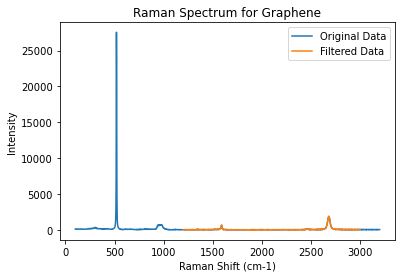

In [4]:
# Create a plot of the original data
plt.plot(data[:,0] , data[:,1] , label='Original Data')

# Use the built in 'filter_data' method to remove data in the Spectrum object outside of the 1200 - 3000 cm-1 range.
spec.filter_data(1200,3000)

# Plot the filtered data on the same plot as the original data.
plt.plot(spec.data_x , spec.data_y , label='Filtered Data')

# Add titles and a legends to the plot to make it look better.
plt.xlabel('Raman Shift (cm-1)')
plt.ylabel('Intensity')
plt.title('Raman Spectrum for Graphene')
plt.legend()

## General considerations for the fitting process
There are several ways that the *RamanAnalysis* module can be used to fit a set of peaks to a set of data. In the following sections we will discuss the strategies that one can take to accomplish this task. In this section, however, we will give an overview of the process and discuss some of the options.

The basic flow of the fitting process is as follows:
1. Create a Spectrum object from X and Y data.
2. Pre-process the data as desired (e.g. filtering the data to a desired range).
3. Specify an initial model to be fitted to the data.
4. Run the fitting process to optimize the initial model for the data to be fitted.

A more detailed discussion of the process:
### Step 1: Create a Spectrum object
We have already discussed how to accomplish item number 1 in the preceeding sections.

### Step 2: Pre-process data
This is highly dependent on the particulars of what the user wants to accomplish. For instance, some users may want to normalize their Intensity data before performing the fitting process.

### Step 3: Specify an initial model
In order for the fitting routine to work, it must have a model which it can optimize to fit the data its given. Since we're fitting a Raman spectrum, the model that we will provide the fitting routine will have several peaks and possibly a baseline. As with any curve-fitting process, it is important to give the fitting routine an initial model that is 'reasonably close' to the data that it is intended to fit (otherwise the fitting may return a non-sensical result or even fail completely).

The Spectrum class has a property called 'model'. This is intended to store the initial guess for fitting and defaults to a value of 'None' when a Spectrum object is created. It is important to note that the fitting process will not proceed unless this default is overwritten with an actual model. A model can be specified in one of two ways:
1. Use a pre-defined or user-supplied model
2. Use a peak-finding routine to automcatically generate an approximate model from the data.

**[Need to update this section after making use of the 'material' property during the fitting process]**

### Step 4: Run the fitting routine
This involves calling a function from the *RamanAnalysis* module to handle the optimization process. The optimizing process uses the 'model' property of the Spectrum object.

# Examples of fitting process flows

## Method 1: Fitting a spectrum using a pre-defined (or User-defined) model
The *RamanAnalysis* module comes with a several pre-defined models, including for one graphene. We will use this model with the data we already imported (and used to make a Spectrum object) for demonstration purposes.

### Specify a model
Since we already have a pre-defined model to use for fitting our data, we only need to use the 'make_composite_model' method to assign the model to the 'model' property of our Spectrum object. This works by taking in the pre-defined model for graphene, which contains information about the center position, height and full width at half maximum (FWHM) for each of the expected individual peaks, and make a single, composite model containing all the peaks. In addition to the expected peaks, it also includes a baseline model to handle non-zero baselines in the data.

In [5]:
# Call the 'make_composite_model' method to create the model to be used for fitting
spec.make_composite_model(RamanAnalysis.model_graphene)

### Run the fitting routine
Now that the model to be used for fitting has been created, we are ready to run the fitting routine. The *RamanAnalysis* module requires only a single command to do this:

In [6]:
spec.fit_spectrum()

### Examine the fitting results
With the fitting done, let's now look at the results. To do so, we will need to access another property of the Spectrum object: the 'result' property. This property stores the results outputted by the lmfit package after its fitting routine is completed. 

One way to see the results is to use a method provided by *lmfit's* output to generate a table summarizing the fitting process. This method is called 'fit_report' and is shown below. This method of showing data isn't always easy to read, but does provide a lot information.

Another way we can see the results of the fitting routine is to visualize the final fit to the original data, and also look at the fitting "residuals". The result output from *lmfit* also provides a convenient way to do this, as shown below.

[[Model]]
    ((((Model(constant, prefix='back_') + Model(lorentzian, prefix='pk_D_')) + Model(lorentzian, prefix='pk_G_')) + Model(gaussian, prefix='pk_DplusDprime_')) + Model(voigt, prefix='pk_2D_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 1401
    # variables        = 13
    chi-square         = 8656749.13
    reduced chi-square = 6236.85096
    Akaike info crit   = 12255.2005
    Bayesian info crit = 12323.3847
##  Warning: uncertainties could not be estimated:
    pk_D_center:               at initial value
    pk_DplusDprime_center:     at initial value
    pk_2D_center:              at initial value
[[Variables]]
    back_c:                    47.9155519 (init = 18.0125)
    pk_D_amplitude:            1530.74354 (init = 1790.708)
    pk_D_center:               1350.00000 (init = 1350)
    pk_D_sigma:                19.1801392 (init = 19)
    pk_G_amplitude:            11889.0812 (init = 13194.69)
    pk_G_center:  

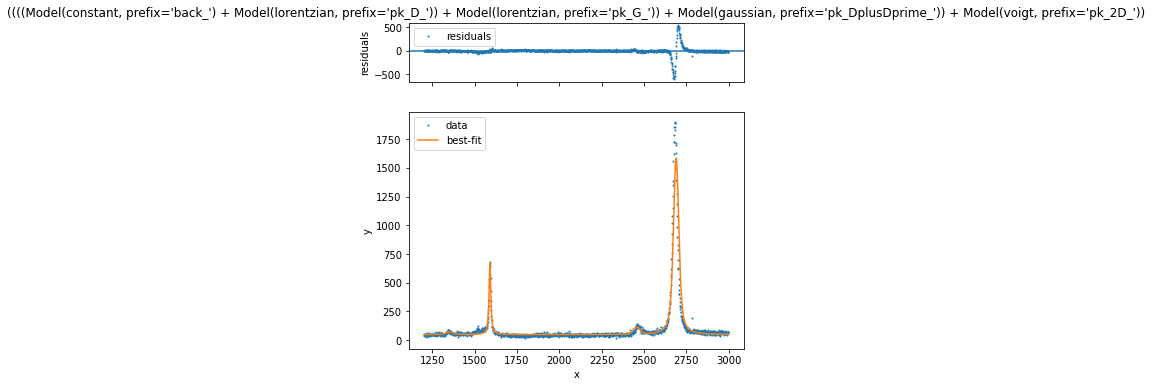

In [7]:
# Print out the fit report generated by lmfit
print(spec.results.fit_report())

fig1, ax1 = spec.results.plot(data_kws={'markersize': 1})

## Method 2: Fitting using an automatically-generated peak model

### Specify a model
Unlike the previous example, we won't be using a saved (or user-defined) model for fitting. Instead, we will use functionality built into the *RamanAnalysis* module to automatically detect peaks from the data and generate a new model from this information. 

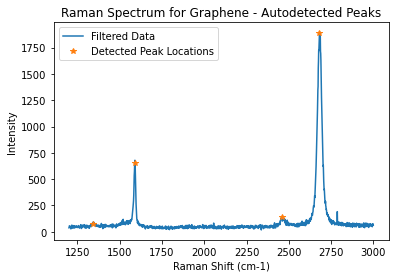

In [8]:
# Locate the peaks in the data and determine parameter values.
peak_indices , peak_properties = spec.locate_peaks()

# Generate a plot to visualize the peak detection results
plt.plot(spec.data_x,spec.data_y,label='Filtered Data')
plt.plot(spec.data_x[peak_indices],spec.data_y[peak_indices],'*',label='Detected Peak Locations')
plt.xlabel('Raman Shift (cm-1)')
plt.ylabel('Intensity')
plt.title('Raman Spectrum for Graphene - Autodetected Peaks')
plt.legend()

new_model_parameters = spec.generate_model_parameters(peak_indices,peak_properties)

spec.make_composite_model(new_model_parameters)

### Run fitting routine and examine the results
This part of the process is the same as before, so we won't rehash the discussion here.

[[Model]]
    ((((Model(constant, prefix='back_') + Model(lorentzian, prefix='peak_0_')) + Model(lorentzian, prefix='peak_1_')) + Model(lorentzian, prefix='peak_2_')) + Model(lorentzian, prefix='peak_3_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 158
    # data points      = 1401
    # variables        = 13
    chi-square         = 654594.885
    reduced chi-square = 471.610147
    Akaike info crit   = 8637.70922
    Bayesian info crit = 8705.89346
##  Warning: uncertainties could not be estimated:
    peak_0_center:     at initial value
    peak_0_sigma:      at boundary
    peak_1_center:     at initial value
    peak_3_center:     at initial value
[[Variables]]
    back_c:            44.4016809 (init = 18.0125)
    peak_0_amplitude:  2312.53109 (init = 1214.713)
    peak_0_center:     1345.33000 (init = 1345.33)
    peak_0_sigma:      26.8288484 (init = 5.36577)
    peak_1_amplitude:  12228.3448 (init = 11465.86)
    peak_1_center:     1589.05000 

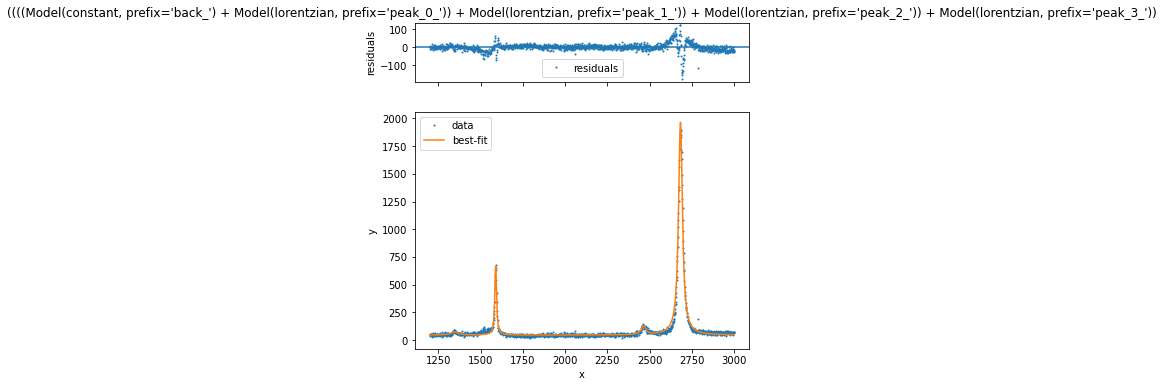

In [9]:
# Use the fitting routine to optimize the auto-generated model.
spec.fit_spectrum()

# Print out the fit report generated by lmfit
print(spec.results.fit_report())

# Create a plot to visualize the results
fig1, ax1 = spec.results.plot(data_kws={'markersize': 1})